In [1]:
from xml.dom.minidom import parseString

In [2]:
fname = './data/DHO_cwv.gpx'
doc = open(fname).read()
dom = parseString(doc)

After looking a the file, it is apparent that all the interesting information is wrapped in  `<trkpt>` tags

In [3]:
pts = dom.getElementsByTagName('trkpt'); print(len(pts))

801


To prototype the conversion to Python numerical types, let's look at an example:
```xml
<trkpt lat="43.15733" lon="-70.976616"><ele>48.8</ele><extensions><x:speed>0.0</x:speed></extensions><time>2016-02-28T18:21:04.000Z</time></trkpt>
```

In [4]:
pt0 = pts[0]
lat = float(pt0.attributes['lat'].value) #the value a named attribute of <trkpt>
lon = float(pt0.attributes['lon'].value) #the value a named attribute of <trkpt>
ele = float(pt0.getElementsByTagName("ele")[0].firstChild.data)  #the value in a Text node the first and only child in this tag
speed = float(pt0.getElementsByTagName("x:speed")[0].firstChild.data)
time_str = pt0.getElementsByTagName("time")[0].firstChild.data
print(lat,lon,ele, speed); print(time_str)

43.15733 -70.976616 48.8 0.0
2016-02-28T18:21:04.000Z


Now we should convert that pesky time string into a nice simple Unix Epoch time, lets check out the `strptime` of `datetime` objects, see this [doc link](https://docs.python.org/2/library/datetime.html#strftime-strptime-behavior)


In [5]:
from datetime import datetime 
dt = datetime.strptime(time_str, "%Y-%m-%dT%H:%M:%S.%fZ")
print(repr(dt))
ts = dt.strftime("%s")
print(ts)

datetime.datetime(2016, 2, 28, 18, 21, 4)
1456701664


Let's throw all these components into a big loop that generates the CSV output directly, here's the whole program:

In [1]:
from xml.dom.minidom import parseString
from datetime import datetime 
import os


fname = './data/DHO_cwv.gpx'
doc = open(fname).read()
dom = parseString(doc)

pts = dom.getElementsByTagName('trkpt')

csv_lines = []
for pt in pts:
    line = []
    #timestamp
    time_str = pt.getElementsByTagName("time")[0].firstChild.data
    dt = datetime.strptime(time_str, "%Y-%m-%dT%H:%M:%S.%fZ")
    line.append(dt.strftime("%s"))
    #lattitude
    line.append(pt.attributes['lat'].value)
    #longitude
    line.append(pt.attributes['lon'].value)
    #elevation
    line.append(pt.getElementsByTagName("ele")[0].firstChild.data)
    #speed
    line.append(pt.getElementsByTagName("x:speed")[0].firstChild.data)
    #format and append line
    csv_lines.append(",".join(line))
    
#finish up by smashing all the lines together
csv_string = "\n".join(csv_lines)

#save the data in a suitably named file
base, ext = os.path.splitext(fname)
csv_filename = "%s.csv" % base
outfile = open(csv_filename, 'w')
outfile.write(csv_string)
outfile.close()

For fun, we will read back the CSV file and plot some columns

In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt # getting specific plotting functions
import pandas as pd # nice data utilities

In [7]:

D = pd.read_table(csv_filename, 
                  header = 0, 
                  sep    =',',
                  names  = ['timestamp','lattitude','longitude', 'elevation', 'speed']);

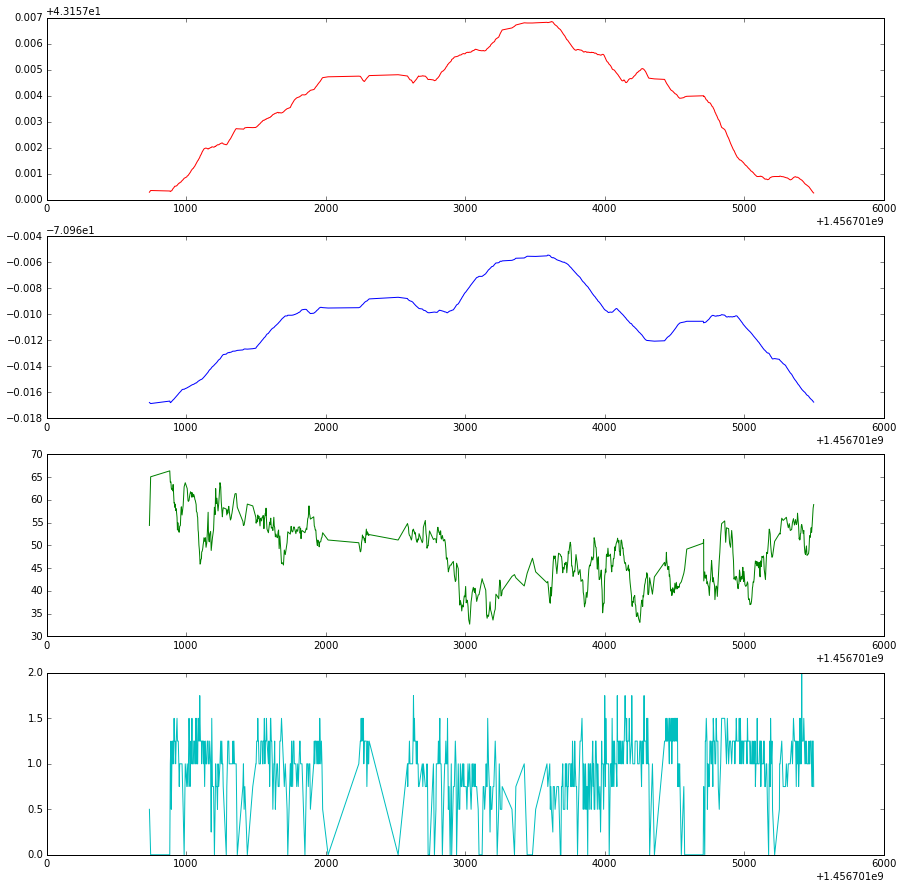

In [17]:
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)
ax3 = fig.add_subplot(413)
ax4 = fig.add_subplot(414)
ax1.plot(D.timestamp, D.lattitude, 'r');
ax2.plot(D.timestamp, D.longitude, 'b');
ax3.plot(D.timestamp, D.elevation, 'g');
ax4.plot(D.timestamp, D.speed, 'c');